In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils_bb import *
from utils_walkdemo import *
import scipy
from skimage import color,io

In [87]:
res = np.loadtxt('keys/test.ply')

In [94]:
np.array([[[res[i,3],res[i,4],res[i,5]]]]).astype(np.uint8)

array([[[119, 134, 153]]], dtype=uint8)

In [9]:
[max(res[:,0]), min(res[:,0])]

[0.787243, -1.447107]

In [44]:
l_x= [max(res[:,0]), min(res[:,0])]
int(np.around((l_x[0] - l_x[1])/0.1))

22

In [95]:
def from_ply_to_minecraft(res, cube_size):
    l_x = [max(res[:,0]), min(res[:,0])]
    n_x = int(np.around((l_x[0] - l_x[1])/cube_size)) # x is height plus negative
    l_y = [max(res[:,1]), min(res[:,1])]
    n_y = int(np.around((l_y[0] - l_y[1])/cube_size))
    l_z = [max(res[:,2]), min(res[:,2])]
    n_z = int(np.around((l_z[0] - l_z[1])/cube_size))
    camera_pos = [int(np.floor((l_x[0])/cube_size)), 
                  int(np.floor((-l_y[1])/cube_size)), int(np.floor((-l_z[1])/cube_size))]
    # initilization of index in 3d world
    box3d = []
    list_direction = []
    list_direction.append(camera_pos)
    for i in range(n_x+1):
        box3d.append(scipy.sparse.coo_matrix((n_y+1,n_z+1),dtype=np.int8).tolil())
    #fill the two lists
    num_cube = 0
    for i in range(len(res)):
        x = int(np.floor((l_x[0] - res[i,0])/cube_size))
        y = int(np.floor((res[i,1] - l_y[1])/cube_size))
        z = int(np.floor((res[i,2] - l_z[1])/cube_size))
        rgb = np.array([[[res[i,3],res[i,4],res[i,5]]]]).astype(np.uint8)
        if box3d[x][y,z] == 0:
            box3d[x][y,z] = num_cube+1
            idx = {}
            idx['x'] = x - camera_pos[0]
            idx['y'] = y - camera_pos[1]
            idx['z'] = z - camera_pos[2]
            idx['density'] = 1
            idx['rgb'] = color.rgb2lab(rgb)
            list_direction.append(idx)
            num_cube = num_cube + 1
        else :
            idx = list_direction[box3d[x][y,z]]
            temp = idx['density']*idx['rgb'] + color.rgb2lab(rgb)
            idx['density'] = idx['density'] + 1
            idx['rgb'] = temp/idx['density'] 
    return box3d, list_direction 

In [96]:
a,b = from_ply_to_minecraft(res, 0.1)

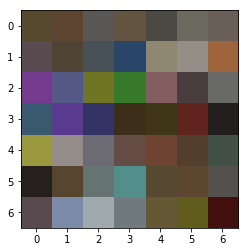

In [60]:
map_rgb = io.imread("colour_map.png")
plt.imshow(map_rgb)

In [89]:
res.shape

(20480, 6)

In [91]:
map_rgb[0,0,:]

array([86, 74, 46], dtype=uint8)

In [99]:
def labcolor_to_blockid(lab, map_lab):
    colours = {(0, 0): (2, 0),
           (0, 1): (3, 0),
           (0, 2): (4, 0),
           (0, 3): (5, 0),
           (0, 4): (7, 0),
           (0, 5): (14, 0),
           (0, 6): (15, 0),
           (1, 0): (16, 0),
           (1, 1): (17, 0),
           (1, 2): (21, 0),
           (1, 3): (22, 0),
           (1, 4): (24, 0),
           (1, 5): (35, 0),
           (1, 6): (35, 1),
           (2, 0): (35, 2),
           (2, 1): (35, 3),
           (2, 2): (35, 4),
           (2, 3): (35, 5),
           (2, 4): (35, 6),
           (2, 5): (35, 7),
           (2, 6): (35, 8),
           (3, 0): (35, 9),
           (3, 1): (35, 10),
           (3, 2): (35, 11),
           (3, 3): (35, 12),
           (3, 4): (35, 13),
           (3, 5): (35, 14),
           (3, 6): (35, 15),
           (4, 0): (41, 0),
           (4, 1): (42, 0),
           (4, 2): (43, 0),
           (4, 3): (45, 0),
           (4, 4): (46, 1),
           (4, 5): (47, 0),
           (4, 6): (48, 0),
           (5, 0): (49, 0),
           (5, 1): (54, 0),
           (5, 2): (56, 0),
           (5, 3): (57, 0),
           (5, 4): (58, 0),
           (5, 5): (60, 0),
           (5, 6): (61, 0),
           (6, 0): (73, 0),
           (6, 1): (79, 0),
           (6, 2): (80, 0),
           (6, 3): (82, 0),
           (6, 4): (89, 0),
           (6, 5): (103, 0),
           (6, 6): (246, 0)}
    distance = 300
    for k, map_column in enumerate(map_lab):
        for l, map_pixel in enumerate(map_column):
            delta = color.deltaE_cie76(lab.reshape(3),map_pixel)
            #print(delta, map_pixel)
            if delta < distance:
                distance = delta
                block = colours[(k,l)]
    return block

In [100]:
def minecraft_xyz_block( list_direction ):
    num = len(list_direction) - 1
    xyz = np.zeros((num,3),dtype=np.int8)
    blocks = []
    map_rgb = io.imread("colour_map.png")
    map_lab = color.rgb2lab(map_rgb)
    
    for i in range(num):
        xyz[i,1] = list_direction[i+1]['x']
        xyz[i,0] = list_direction[i+1]['y']
        xyz[i,2] = - list_direction[i+1]['z']
        blocks.append(labcolor_to_blockid(list_direction[i+1]['rgb'], map_lab))
    
    return xyz, blocks

In [64]:
a,b = from_ply_to_minecraft(res, 0.1)

In [98]:
b[1]['rgb'].reshape(3)

array([72.79561654,  4.69836584, -0.61107391])

In [101]:
xyz, blocks = minecraft_xyz_block( b)

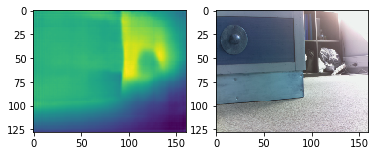

In [125]:
dep = np.load('keys/deps/dep_2.npy')
image = cv2.imread('keys/images/img/2.jpg')
image = cv2.resize(image,(160,128))
plt.subplot(121); plt.imshow(dep.reshape(128,160))
plt.subplot(122); plt.imshow(image)

In [1]:
import os

In [39]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [104]:
mtx = np.eye(3)
mtx[0,0]=200
mtx[1,1]=200
mtx[0,2]=64
mtx[1,2]=80

In [107]:
np.linalg.inv(mtx)

array([[ 0.005,  0.   , -0.32 ],
       [ 0.   ,  0.005, -0.4  ],
       [ 0.   ,  0.   ,  1.   ]])

In [135]:
res_new_image = vert_new(image, dep.reshape((128,160)), np.eye(3,4),mtx, False)
write_ply('keys/'+ str(1111) +'.ply', res_new_image)

In [136]:
res_new_image = vert_alphabot(image, dep.reshape((128,160)), np.eye(3,4),mtx, False)
write_ply('keys/'+ str(111) +'.ply', res_new_image)